In [ ]:
import pickle
import pandas as pd
import os
from glob import glob
import tqdm
import numpy as np
import torch
import json
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [ ]:
import sys
sys.path.append("../../")
from meerkats import config


In [ ]:
distinct_colors_22 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                      '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                      '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                      '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                      '#ffffff', '#000000']

UMAP AND TSNE FUNCTION

In [38]:
def umap_apply_3Dplot(embeddings,labels, mycolors, dim=2, n=15, outname=None, showlegend=True):

    
    """
    Function that creates (and saves) 3D plot from an
    input dataset, color-colored by the provided labels.

    Parameters
    ----------
    x : 1D numpy array (numeric) or list
        x coordinates of datapoints
                
    y: 1D numpy array (numeric) or list 
       y coordinates of datapoints

    z: 1D numpy array (numeric) or list 
       z coordinates of datapoints
    
    scat_labels: List-of-Strings
                 Datapoint labels
                     
    mycolors: String or List-of-Strings
              Seaborn color palette name (e.g. "Set2") or list of
              colors (Hex value strings) used for coloring datapoints
              (e.g. ["#FFEBCD","#0000FF",...])
                     
    outname: String
             Output filename at which plot will be saved
             No plot will be saved if outname is None
             (e.g. "my_folder/my_img.png")
             
    showlegend: Boolean
                Show legend if True, else don't
                
    Returns
    -------
    
    -
             
    """   
    if dim==2:
        umaps=umap.UMAP(n_components=dim,n_neighbors=n).fit_transform(embeddings)
        fig = plt.figure()
    
    
        ax = fig.add_subplot(111)
        ax.scatter(umaps[:,0], umaps[:,1], c=labels)
    


    else:
        umaps=umap.UMAP(n_components=dim,n_neighbors=n).fit_transform(embeddings) 

        labeltypes = sorted(list(set(labels)))
        pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
        color_dict = dict(zip(labeltypes, pal))
        c = [color_dict[val] for val in labels]
        
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        Axes3D.scatter(ax,
                        xs = umaps[:,0],
                        ys = umaps[:,1],
                        zs = umaps[:,2],
                        zdir='z',
                        s=20,
                        label = c,
                        c=c,
                        depthshade=False)

        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.set_zlabel('UMAP3')
        
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')



        if showlegend: 
            scatters = []
            for label in labeltypes:
                scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
            
            ax.legend(scatters, labeltypes, numpoints = 1)
        
    if outname: plt.savefig(outname, facecolor="white")


In [ ]:
def plot_tsne(embeddings,labels,perp=30,outname=None,show_legend=True):
    
    tsne=TSNE(n_components=2,perplexity=perp)
    
    X_embedded=tsne.fit_transform(embeddings)
    num_classes=len(np.unique(labels))
    sns.scatterplot(
    x=X_embedded[:,0],
    y= X_embedded[:,1],
    hue=labels,
    palette=sns.color_palette("hls", num_classes),
    legend="full",
    alpha=0.3
)
    plt.show()
    

    if outname: plt.savefig(outname,facecolor="white")

In [32]:
features=pd.read_csv(config.FEATURES_DIR + "lastlayermara.csv",header=None,index_col=0) # which features set to plot
embeddings=features.iloc[:,:-1].to_numpy()
labels=features.iloc[:,-1].to_numpy()

In [ ]:
perplexity=np.arange(5,50,5)
for i in perplexity:

    plot_tsne(embeddings=embeddings,labels=labels,perp=i)

In [42]:
neighbors=[5,15,50,70,100]

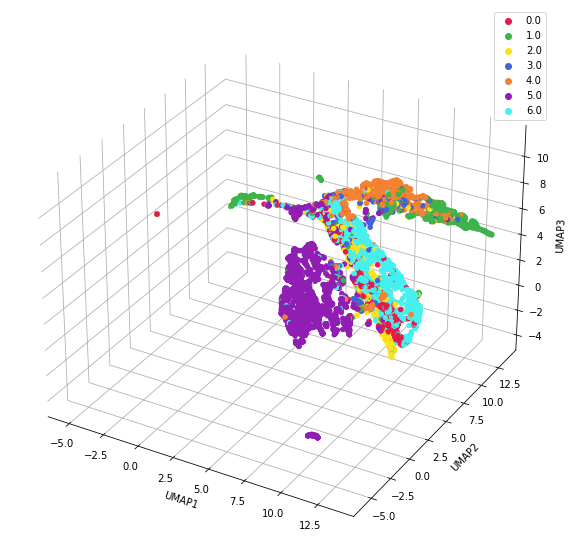

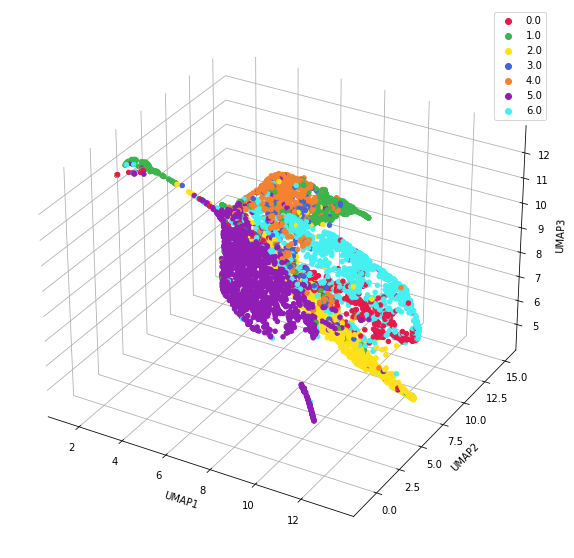

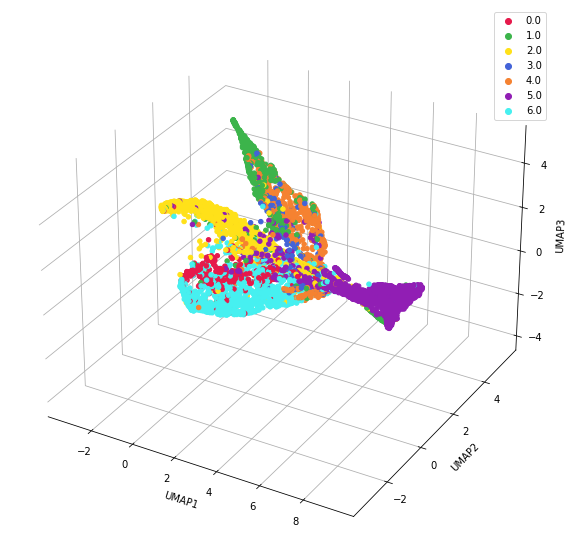

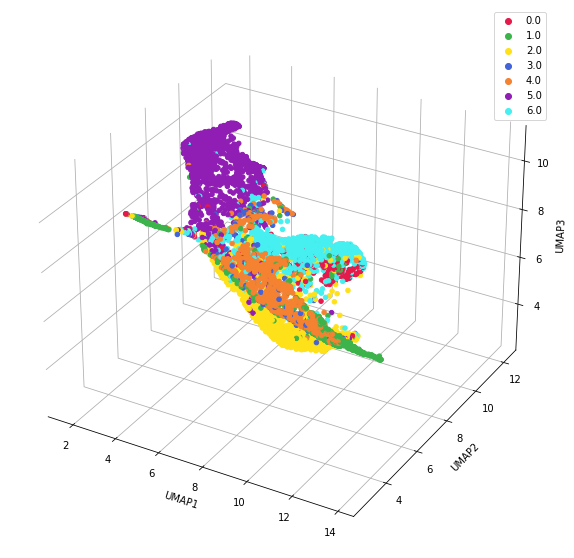

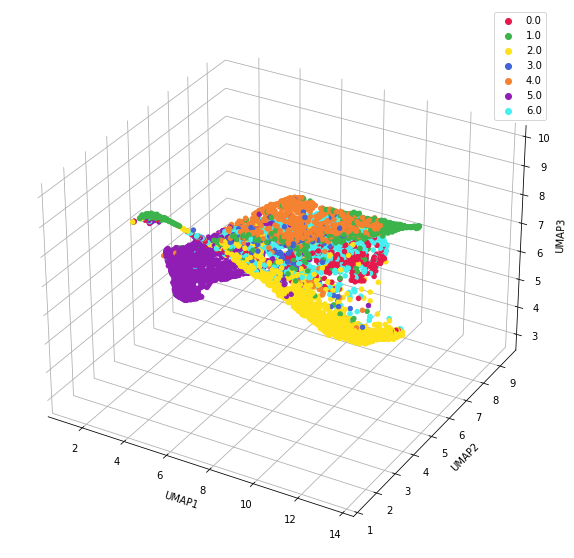

In [44]:
for i in neighbors:
    
    umap_apply_3Dplot(embeddings,labels, distinct_colors_22, dim=3, n=i, outname=None, showlegend=True)



STUDY ON THE SSL FEATURES

In [ ]:
#config.GITROOT="/idiap/project/evolang/meerkats_imen/evolang_meerkats_calls_classification/workspace/"
DATADIR_SLL=config.DATASSL
mara_ssl=os.path.join(DATADIR_SLL,"test")

all_files=glob(mara_ssl + "*.pkl", recursive=True)



In [ ]:
with open(config.GITROOT + '/meerkats/src/data/class_to_index_mara.json') as f:
    class_to_index = json.load(f)
    
info_file=pd.read_csv(config.GITROOT+ "lib/mara-code/data/info_file.csv",sep=";")

    

In [ ]:
embeddingsm=torch.empty(0,768)
labelsm=np.array(())
for emb in all_files:
    with open(emb,"rb") as handle:
        x=pd.read_pickle(emb)
        features_dict=pickle.load(handle)


    filename=emb.split("/")[-1].replace("pkl","wav")

    result = info_file.loc[info_file['filename'] == filename, 'label'].values[0]
    label=class_to_index[result]
    
    layer=features_dict["tfmr_1"]

    #result=torch.cat((torch.mean(layer,dim=0),torch.std(layer,dim=0)))
    labelsm=np.append(labelsm,[label]*layer.shape[0])
    embeddingsm=torch.cat((embeddingsm,layer),dim=0)


In [ ]:
embeddings=np.empty((0,768))
labels=np.array(())
for emb in all_files:
    with open(emb,"rb") as handle:
        x=pd.read_pickle(emb)
        features_dict=pickle.load(handle)

    layer=features_dict["tfmr_1"]
    #result=torch.cat((torch.mean(layer,dim=0),torch.std(layer,dim=0)))

    filename=emb.split("/")[-1]
    class_name=filename.split(".")[0]
    label=class_to_index[class_name]
    
    
    
    labels=np.append(labels,[label]*layer.shape[0])
    embeddings=np.append(embeddings,layer,axis=0)
